# Task 1: Exploratory Analysis & Hypothesis-Driven Bioinformatic Workflow: Second analysis
## Predicting Survival in Colorectal Cancer Patients Using Enriched Cancer Pathway Genes & Metadata

---

## Objectives

- Develop and evaluate predictive survival models for **colorectal cancer**, focusing on identifying **key prognostic genes**.  
- Compare models trained on **combined clinical + gene expression data** versus **gene-expression–only** datasets.  
- Determine which genes and features most influence model predictions for biological and clinical interpretation.  

---

## Tools & Methods

- **scikit-survival** – survival modeling & evaluation metrics  
- **scikit-learn** – preprocessing, feature selection (F-statistics), imputation (MICE), permutation importance  
- **Seaborn / Matplotlib** – visualization of results and feature importance  

---

## Workflow Overview

1. **Data Preparation**  
   - Load **TMM-normalized, log-transformed enriched gene expression** (from hallmark GSEA) and metadata.  
   - Split into **features (X)** and **outcome (y)**, then into **training (80%)** and **testing (20%)** sets, stratified by event.  
   - On the training set:  
     - Select top features (e.g., 50 genes/variables) using **F-statistics**.  
     - Encode categorical variables, scale numerical features (Z-score), and impute missing values using **Iterative Imputer (MICE)**.  

2. **Model Development**  
   - Train and hyper-tune **Random Survival Forest** and **Survival Gradient Boosting** models via 3-fold cross-validation.  
   - Evaluate on the test set using:  
     - **Concordance Index (C-index)**  
     - **Integrated Brier Score (IBS)**  
     - **AUC**  

3. **Feature Importance Analysis**  
   - Use **permutation importance** (100 iterations) to rank genes and clinical variables by their contribution to model predictions.  
   - Interpret top genes in the context of colorectal cancer biology.  

4. Future step: **Gene-Only Analysis**  
   - Repeat the workflow using **only gene expression features** to assess predictive performance compared to the combined model and have a stronger gene signal.  


## Key Considerations

- **Feature selection** (top 50 genes) was essential for reducing dimensionality while keeping models interpretable, I chose 50 after some testing, it needs to be automatized for a pipeline.  
- **Selection** was chosen over dimensionality reduction to maintain feature-level interpretability for tree-based models.  
- **Tree-based survival models** were preferred over Cox or Kaplan-Meier methods for capturing non-linear and complex relationships.  

---

**Note:**  
This analysis is automated in the `scripts` folder with configurable parameters.  
The pipeline is also tested with different number of selected features at the end of the notebook for demonstration.  

**References**
- Soleimani, S., Bahrami, M., & Vali, M. (2025). Survival prediction from imbalanced colorectal cancer dataset using hybrid sampling methods and tree-based classifiers. Scientific Reports, 15, 14554. https://doi.org/10.1038/s41598-025-98703-8
- El Badisy, I., BenBrahim, Z., Khalis, M., et al. (2024). Risk factors affecting patient survival with colorectal cancer in Morocco: survival analysis using an interpretable machine learning approach. Scientific Reports, 14, 3556. https://doi.org/10.1038/s41598-024-51304-3


In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc, integrated_brier_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
import sys
import scanpy as sc
sys.path.append('../scripts')  

import plotting_utils as mplt
from survival_cancer import run_pipeline
sys.path.append('../notebooks')  



In [2]:
# load processed dataframes
metadata_df = pd.read_csv('../data/cancer_metadata.csv', index_col=0)
expression = pd.read_csv('../data/cancer_tmm_log.csv', index_col=0)

### Data Filtering & Preparation

Before feature selection, transformation, and imputation, I applied a **survival time filter**:  
- Removed cases where events occurred in **less than 6 months** of observation.  
- This step reduces bias from events that are difficult to predict when censored too early.  

After filtering:  
- **Cases:** 425 censored and 91 deaths.  
- **Time-to-event distributions** were similar between censored and death cases.  
- Events distribution peaked around **500 days** of survival, with a few extending beyond **5,000 days**.  

Following this filtering, I proceeded with:  
1. Selecting the top 50 features using **F-statistics** on the training set.  
2. Scaling numerical features (Z-score) and label encoding categorical variables.  
3. Imputing missing values using **Iterative Imputer (MICE)** based on feature and metadata similarity.  

These prepared datasets were then used for model training and evaluation.  


In [3]:
# filtering ealy events
metadata_df = metadata_df[(metadata_df['os_time'] >=180)&(metadata_df['os_time'] <=4000)]
expression = expression.loc[metadata_df.index]
expression.shape


(516, 1737)

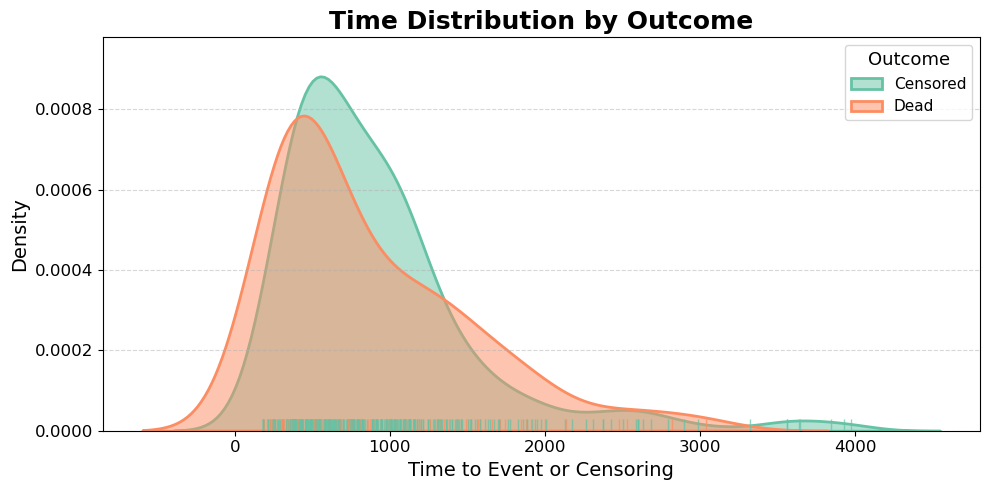

In [4]:
mplt.plot_time_distribution_by_outcome(metadata_df, time_col='os_time', status_col='os_status')

In [5]:
metadata_df['os_status'].value_counts()

os_status
Censored    425
Dead         91
Name: count, dtype: int64

In [6]:
# splitting X and y and preparing right format for scikit survival 
metadata_df["os_status"] = metadata_df["os_status"].map({'Death':True,'Censored':False})

# Ensure os_time is float
metadata_df["os_time"] = metadata_df["os_time"].astype(float)

# Build survival array
y = np.array(
    list(zip(
        metadata_df["os_status"],
        metadata_df["os_time"]
    )),
    dtype=[('event', '?'), ('time', '<f8')]
)

metadata_df = metadata_df.drop(columns=['os_status','os_time'])

In [7]:
# Example: split metadata_df into train and test
train_df, test_df, y_train, y_test = train_test_split(expression, y,test_size=0.2, random_state=42,stratify=y['event'])

# selectin best features from expression
bestk = SelectKBest(score_func=f_classif, k=30)
bestk.fit(train_df,y_train)
X_train_selected = bestk.transform(train_df)
selected_feature_names = train_df.columns[bestk.get_support()]
# Transform and convert back to DataFrames
X_train_selected = pd.DataFrame(
    bestk.transform(train_df),
    columns=selected_feature_names,
    index=train_df.index
)

X_test_selected = pd.DataFrame(
    bestk.transform(test_df),
    columns=selected_feature_names,
    index=test_df.index
)
X_train = X_train_selected.merge(metadata_df, left_index=True, right_index=True)
X_test = X_test_selected.merge(metadata_df, left_index=True, right_index=True)

# Separate categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# ---- 1. Label Encoding ----
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()

    # Fit on train (ignoring NaNs)
    X_train[col] = X_train[col].astype(str).replace('nan', np.nan)
    not_null_mask_train = X_train[col].notnull()
    X_train.loc[not_null_mask_train, col] = le.fit_transform(X_train.loc[not_null_mask_train, col])

    # Transform test using the same encoder
    X_test[col] = X_test[col].astype(str).replace('nan', np.nan)
    not_null_mask_test = X_test[col].notnull()
    X_test.loc[not_null_mask_test, col] = le.transform(X_test.loc[not_null_mask_test, col])

    # Save encoder
    label_encoders[col] = le

# ---- 2. Scaling ----
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ---- 3. Iterative Imputer (MICE) ----
mice_imputer = IterativeImputer()

X_train[categorical_cols] = mice_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = mice_imputer.transform(X_test[categorical_cols])



### Model Tuning & Evaluation

To optimize model performance, I:  
1. Defined a **Concordance Index (c-index)** scorer for use during hyperparameter tuning.  
2. Performed **3-fold cross-validation** hyperparameter tuning for:  
   - **Random Survival Forest (RSF)**  
   - **Gradient Boosting Survival Analysis (GBS)**  

#### Performance Metrics

| Model | AUC   | C-index | IBS   |
|-------|-------|---------|-------|
| RSF   | 0.75 | 0.772   | 0.177 |
| GBS   | 0.78 | 0.792   | 0.181 |

#### Interpretation

- **Gradient Boosting Survival (GBS)** outperformed the Random Survival Forest (RSF) in terms of both **AUC** and **C-index**, indicating better discrimination in predicting survival times.  
- Both models showed **moderate predictive ability** with AUC values above 0.7.
- The RSF achieved a lower **Integrated Brier Score (IBS)** of **0.175**, reflecting better overall calibration and predictive accuracy over time. GBS, with a higher IBS (**0.307**), showed less precise calibration.  
  - This metric is especially important in **imbalanced datasets**, as the IBS is a weighted function — and our dataset is imbalanced.  
- **AUC over time:** Both models maintained strong performance until roughly **1,500 days**, after which performance declined before recovering toward the end of the follow-up period.  
  - This trend suggests survival predictions are more accurate **early** in the observation period and **late** in the follow-up, potentially due to more obvious signals (e.g., age-related mortality).  
  - The **intermediate survival period** is harder to predict, likely because of complex and interacting clinical and biological factors.

---

**Conclusion:**  
Both models performed well overall — **GBS** excelled in discrimination (AUC, C-index), while **RSF** had superior calibration (IBS). Further analysis comparing **feature importance**, **prediction patterns**, and **error sources** would provide valuable insights.



In [8]:
# # custom wrapper function for survival model tuning
def c_index_scorer(estimator, X,y):
    surv_pred = estimator.predict(X)
    result = concordance_index_censored(y['event'], y['time'], surv_pred)
    return result[0]

# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [50,75,100,200,300],
    "max_depth": [2,3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2"]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=3,
    scoring=c_index_scorer,
    random_state=42
)

# 6. Fit the model
random_search.fit(X_train, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
best_rsf.fit(X_train,y_train)
rsf_predict = best_rsf.predict(X_test)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5}


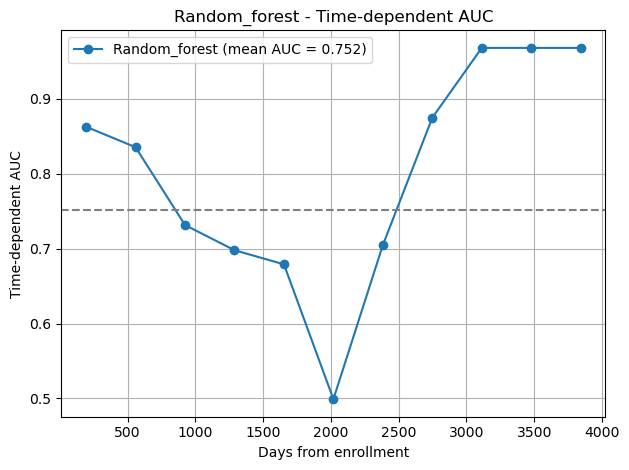

0.7518009011309141

In [9]:
os.makedirs("../results/cancer_survival", exist_ok=True)
# %% AUC Plotting function to be used later
def plot_auc(model_name, y_train, y_test, preds, intervals, output_dir):
    """
    Plot and save time-dependent AUC curve.
    """
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, preds, intervals)
    plt.figure()
    plt.plot(intervals, auc, marker="o", label=f"{model_name} (mean AUC = {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--", color='gray')
    plt.xlabel("Days from enrollment")
    plt.ylabel("Time-dependent AUC")
    plt.title(f"{model_name} - Time-dependent AUC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name}_auc_plot.png"))
    plt.show()
    plt.close()
    return mean_auc
#plot random forest AUC
y_min,y_max = np.min(y_test['time']+10), np.max(y_test['time'])
intervals = np.arange(y_min,y_max,365)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals, "../results/cancer_survival")

In [10]:
# define the gradient boosting forest model
gbs = GradientBoostingSurvivalAnalysis(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": [50,75,100,200],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "learning_rate" : [0.01,0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbs,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# Fit the model
random_search.fit(X_train, y_train)

# View best params
print("Best Parameters:", random_search.best_params_)


# Use the best model
best_gbs = random_search.best_estimator_
best_gbs.fit(X_train, y_train)
gbs_predict = best_gbs.predict(X_test)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.1}


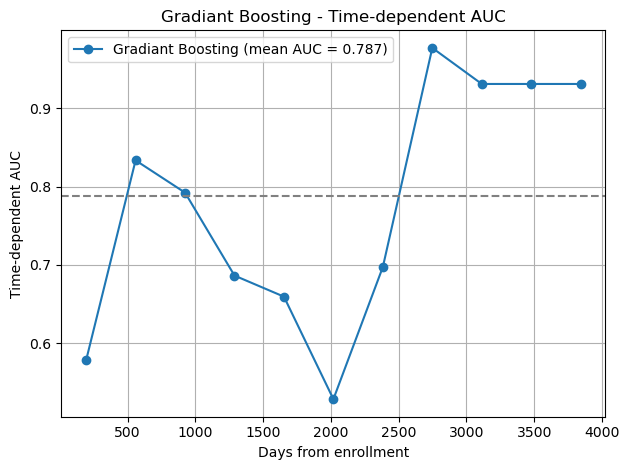

0.7874081988689582

In [11]:
# plot AUC
plot_auc('Gradiant Boosting',y_train,y_test,gbs_predict,intervals, "../results/cancer_survival")

In [12]:
# model evaluation with c index and brier score

rsf_surv_prob = np.vstack([fn(intervals) for fn in best_rsf.predict_survival_function(X_test)])
gbs_surv_prob = np.vstack([fn(intervals) for fn in best_gbs.predict_survival_function(X_test)])

score_cindex = pd.Series(
    [
        best_rsf.score(X_test, y_test),
        best_gbs.score(X_test, y_test),
    ],
    index=["RSF", "GBS"],
    name="c-index",
)
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, intervals)
        for prob in (rsf_surv_prob, gbs_surv_prob)
    ],
    index=["RSF", "GBS"],
    name="IBS",
)

evaluate = pd.concat((score_cindex, score_brier), axis=1).round(3)
evaluate.to_csv('../results/cancer_survival/models_eval.csv')
evaluate


,c-index,IBS
RSF,0.772,0.177
GBS,0.792,0.181


#### Interpretation of Permutation Importance for Survival Random Forest in Colorectal Cancer Overall Survival

The plot presents the permutation importance scores of the top 10 features in the survival random forest model predicting overall survival in colorectal cancer patients. Permutation importance measures the decrease in model performance when the values of a feature are randomly shuffled, thereby indicating the feature's contribution to the model. However it is tricky to understand how the features are affecting the model. For that, SHAPs are easier to interpert. 
Some of the most important features are:

##### Stage

The clinical stage of colorectal cancer shows the highest permutation importance, highlighting its strong prognostic value. This aligns with extensive literature establishing tumor stage as the most critical factor influencing survival outcomes 

**References:**

- Rawla P, Sunkara T, Barsouk A. Epidemiology of colorectal cancer: incidence, mortality, survival, and risk factors. Prz Gastroenterol. 2019;14(2):89-103. doi:10.5114/pg.2018.81072.

---
##### ITGB1BP2

ITGB1 is a heterodimeric cell-surface receptor involved in cell functions such as proliferation, migration, invasion and survival.

**Reference:**

- Liu QZ, Gao XH, Chang WJ, Gong HF, Fu CG, Zhang W, Cao GW. Expression of ITGB1 predicts prognosis in colorectal cancer: a large prospective study based on tissue microarray. Int J Clin Exp Pathol. 2015 Oct 1;8(10):12802-10. PMID: 26722470; PMCID: PMC4680415.
---

##### BNC1 

A zinc finger protein-specific transcription factor associated with different types of cancers, like pancreatic cancer.

**Reference:**

- Eissa MAL, Lerner L, Abdelfatah E, Shankar N, Canner JK, Hasan NM, Yaghoobi V, Huang B, Kerner Z, Takaesu F, Wolfgang C, Kwak R, Ruiz M, Tam M, Pisanic TR 2nd, Iacobuzio-Donahue CA, Hruban RH, He J, Wang TH, Wood LD, Sharma A, Ahuja N. Promoter methylation of ADAMTS1 and BNC1 as potential biomarkers for early detection of pancreatic cancer in blood. Clin Epigenetics. 2019 Apr 5;11(1):59. doi: 10.1186/s13148-019-0650-0. PMID: 30953539; PMCID: PMC6451253.
---

##### egfr mutation 

Epidermal growth factor receptor mutation, has anti-EGFR antibodies for targeted therapy. Present in 3% CRC pateints especially in adenocarinoma.

**Reference:**

- Kim N, Cho D, Kim H, Kim S, Cha YJ, Greulich H, Bass A, Cho HS, Cho J. Colorectal adenocarcinoma-derived EGFR mutants are oncogenic and sensitive to EGFR-targeted monoclonal antibodies, cetuximab and panitumumab. Int J Cancer. 2020 Apr 15;146(8):2194-2200. doi: 10.1002/ijc.32499. Epub 2019 Jul 9. PMID: 31290142.
---

### Summary

The models highlight both established clinical features (stage) and molecular biomarkers as key predictors of overall survival in colorectal cancer


In [ ]:
def plot_permutation_importance(model, X_test, y_test, model_name='Model', n_repeats=100, random_state=42,output_dir=None):
    """
    Computes and plots permutation importance for a fitted model.
    Plots only the top 10 features by absolute importance,
    but displays their original (signed) importances.
    """
    result = permutation_importance(model, X_test, y_test,
                                     n_repeats=n_repeats,
                                     random_state=random_state)
    
    # Get indices for top 10 absolute importances
    abs_importances = np.abs(result.importances_mean)
    top10_idx = np.argsort(abs_importances)[-10:]
    
    # Sort top 10 by actual (signed) mean importance for nicer plot order
    top10_idx = top10_idx[np.argsort(result.importances_mean[top10_idx])]
    
    # Plot
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[top10_idx].T,
               vert=False,
               labels=X_test.columns[top10_idx])
    ax.set_title(f'Permutation Importance - Top 10 Absolute ({model_name})')
    fig.tight_layout()
    plt.show()
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        fig_path = os.path.join(output_dir, f'permutation_importance_{model_name}.png')
        fig.savefig(fig_path)
        print(f'Saved permutation importance plot to {fig_path}')
    
    plt.show()
#plotting important features
plot_permutation_importance(best_rsf, X_test, y_test, model_name='RSF',output_dir='../results/cancer_survival/')
plot_permutation_importance(best_gbs, X_test, y_test, model_name='GBS',output_dir='../results/cancer_survival/')


### Demonstrating Pipeline Use & Important Consideration

- The pipeline can be improved by tuning the number of selected features (K) and automating data preprocessing.

- Applying oversampling techniques, such as SMOTE, can help address class imbalance.

- For important features with many missing values, like chromosome instability, it can be beneficial to flag missing values and retain that information.

- For long-term survival prediction, incorporating competing risk information may improve results by adding valuable context.

- Implementing SHAP for feature importance and comparing it with permutation can be interesting as well, it gives more information on the direction of the effect. SurvivalSHAP can be used to study importance at different time points.

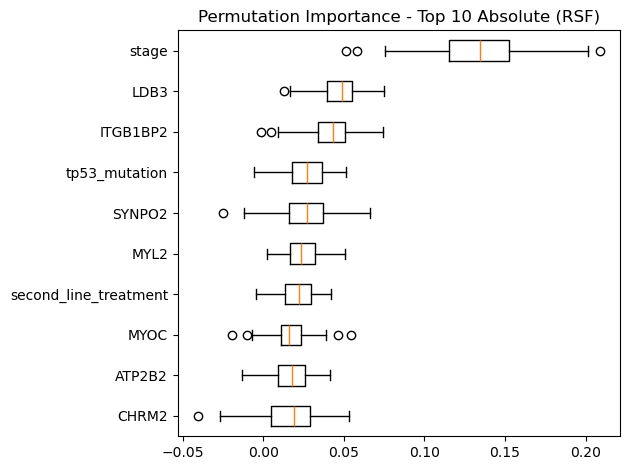

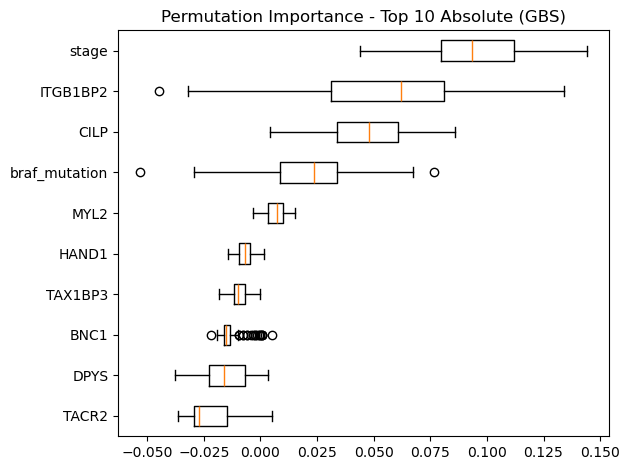

  Model   C-index       IBS  Mean AUC
0   RSF  0.784330  0.175966  0.746017
1   GBS  0.754002  0.185291  0.806731


In [ ]:
# running for 25 best features using pipeline
run_pipeline(k_features = 25,output_dir="../results/cancer_survival_25")